# Evaluation

The `Evaluation` class is the actual interface for the user with the
functionalities of the `pyEvalData` package. It provides access to the raw
data via the `Source` object, given on initialization.  
The main features of the `Evaluation` class are the definition of counter
aliases as well as new counters by simple algebraic expressions.
At the same time pre- and post-filters can be applied to the raw and
evaluated data, respectively.
Much efforts have been put into the binning, averaging, and error calculation
of the raw data.
In addition to the evaluation of a list of scans or scan sequence of one or
multiple scans in dependence of an external paramter, the `Evaluation` class
also provides high-level helper functions for plotting and fitting the
according results.

## Setup

Here we do the necessary import for this example

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import pyEvalData as ped
# import lmfit for fitting
import lmfit as lf
# import some usefull fit functions
import ultrafastFitFunctions as ufff
# define the path for the example data
example_data_path = '../../../example_data/'

## Source

Here we iitialize the `Source` for the current evaluation. It is based on raw
data in a [SPEC file](https://certif.com/content/spec) which was generated by
the open-source software [Sardana](https://sardana-controls.org).

In [2]:
spec = ped.io.Spec(file_name='sardana_spec.spec',
                   file_path=example_data_path,
                   use_nexus=True,
                   force_overwrite=False,
                   update_before_read=False,
                   read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_nexus


## Initialization of `Evaluation` object

For the most basic example we just have to provide a `Source` on initialization: 

In [3]:
ev = ped.Evaluation(spec)

Now it is possible to check the available attributes of the `Evaluation`
object, which will be explained step-by-step in the upcominng sections.

In [4]:
print(ev.__doc__)

Evaluation

    Main class for evaluating data.
    The raw data is accessed via a ``Source`` object.
    The evaluation allows to bin data, calculate errors and propagate them.
    There is also an interface to ``lmfit`` for easy batch-fitting.

    Args:
        source (Source): raw data source.

    Attributes:
        log (logging.logger): logger instance from logging.
        clist (list[str]): list of counter names to evaluate.
        cdef (dict{str:str}): dict of predefined counter names and
            definitions.
        xcol (str): counter or motor for x-axis.
        t0 (float): approx. time zero for delay scans to determine the
            unpumped region of the data for normalization.
        custom_counters (list[str]): list of custom counters - default is []
        math_keys (list[str]): list of keywords which are evaluated as numpy functions
        statistic_type (str): 'gauss' for normal averaging, 'poisson' for counting statistics
        propagate_errors (bool): 

## Simple plot example

To plot data, the `Evlauation` objects does only need to know the `xcol` as
horizontal axis as well a list of *counters* to plot, which is called `clist`.

First we can check the available scan numbers in the source:

In [5]:
spec.get_all_scan_numbers()

[1, 2, 3, 4, 5, 6]

Now we can check for the available data for a specific scan

In [6]:
spec.scan1.data.dtype.names

('Diff',
 'DiffM',
 'Pt_No',
 'Pumped',
 'PumpedErr',
 'PumpedErrM',
 'PumpedM',
 'Rel',
 'RelM',
 'Unpumped',
 'UnpumpedErr',
 'UnpumpedErrM',
 'UnpumpedM',
 'chirp',
 'delay',
 'dt',
 'duration',
 'durationM',
 'envHumid',
 'envTemp',
 'freqTriggers',
 'magneticfield',
 'numTriggers',
 'numTriggersM',
 'thorlabsPM',
 'thorlabsPPM',
 'thorlabsPPMonitor')

So let's try to plot the counters `Pumped` and `Unpumped` vs the motor `delay` for scan #1: 

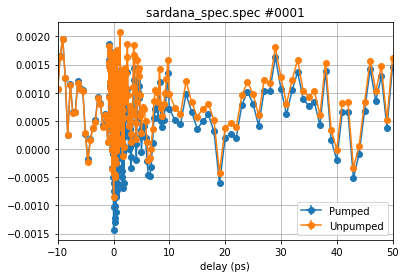

In [7]:
ev.xcol = 'delay'
ev.clist = ['Pumped', 'Unpumped']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

## Algebraic expressions

For now, we only see a lot of noise. So let's work a bit further on the data we
plot. The experiment was an ultrafast [MOKE](https://en.wikipedia.org/wiki/Magneto-optic_Kerr_effect)
measurement, which followed the polarization rotation of the probe pulse after
a certain `delay` in respect to the pump pulse. Typically, this magnetic contrast
is improved by subtracting the measured signal for two opposite magnetization
directions of the sample, as the MOKE effect depends on the sample's magnetization.

In our example, we have two additional *counters* available, which contain the
data for negative magnetic fields (*M* - minus): `PumpedM` and `UnpumpedM`  
While the two former *counters* were acquired for positive fields.

Let's plot the difference signal for the *pumped* and *unpumped* signals:

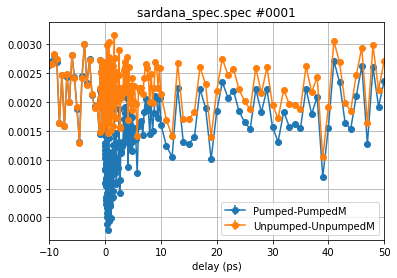

In [8]:
ev.xcol = 'delay'
ev.clist = ['Pumped-PumpedM', 'Unpumped-UnpumpedM']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

The new plot shows already much more dynamisc in the *pumped* vs. the *unpumped*
signal. However, we can still improve that, by normalizing one by the other:

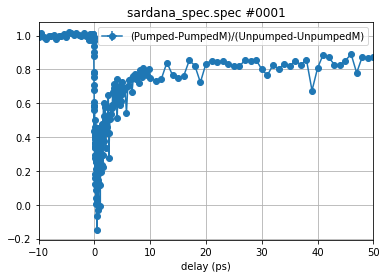

In [9]:
ev.xcol = 'delay'
ev.clist = ['(Pumped-PumpedM)/(Unpumped-UnpumpedM)']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

This does look much better but we lost the absolute value of the contrast.
Let's simply multiply the trace with the average of the *unpumped* magnetic
contrast:

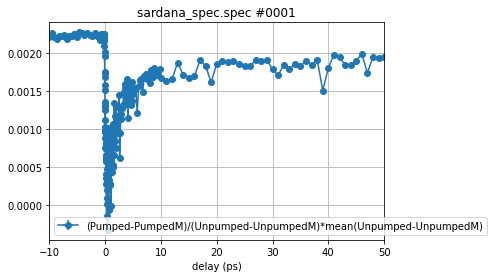

In [10]:
ev.xcol = 'delay'
ev.clist = ['(Pumped-PumpedM)/(Unpumped-UnpumpedM)*mean(Unpumped-UnpumpedM)']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

So besides simple operations such as `+. -. *, /` we can also use some basic
`numpy` functionalities. You can check the available functions by inspection
of the attribute `math_keys`:

In [11]:
ev.math_keys

['mean',
 'sum',
 'diff',
 'max',
 'min',
 'round',
 'abs',
 'sin',
 'cos',
 'tan',
 'arcsin',
 'arccos',
 'arctan',
 'pi',
 'exp',
 'log',
 'log10',
 'sqrt']

But of course our current *counter* name is rather bulky. So lets define some
aliases using the attribute `cdef`:

In [12]:
ev.cdef['pumped_mag'] = 'Pumped-PumpedM'
ev.cdef['unpumped_mag'] = 'Unpumped-UnpumpedM'
ev.cdef['rel_mag'] = 'pumped_mag/unpumped_mag'
ev.cdef['abs_mag'] = 'pumped_mag/unpumped_mag*mean(unpumped_mag)'

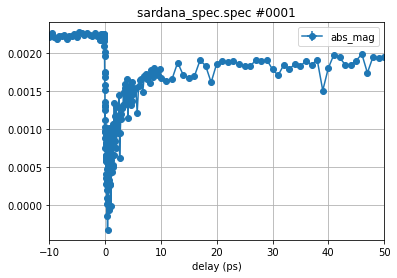

In [13]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

## Binning

In many situations it is desireable to reduce the data density or to plot the
data on a new grid. This can be easily achieved by the `xgrid` keyword of the
`plot_scans` method.

Here we plot the same data as before on a three reduced grids with 0.1, 1, and
5 ps step width. Please note that the errorbars appear due to the averaging of
multiple point in the bins of the grid. The errorbars are vertical and horizontal.
We can also skip the `xlim` setting here, as our grid is in the same range as
before.

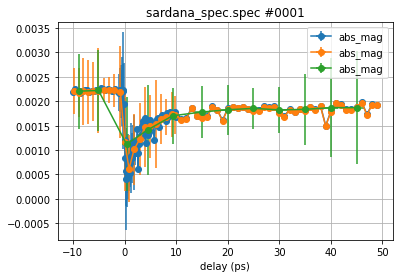

In [14]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([1], xgrid=np.r_[-10:50:1])
ev.plot_scans([1], xgrid=np.r_[-10:50:5])
plt.xlabel('delay (ps)')
plt.show()

## Averaging

In order to improve statistics even further, scan are repeated an averaged.
This was also done for this experimental example and all scans #1-6 were done
with the same settings.

We can simply average them by providing all scans of interest to the `plot_scans`
method:

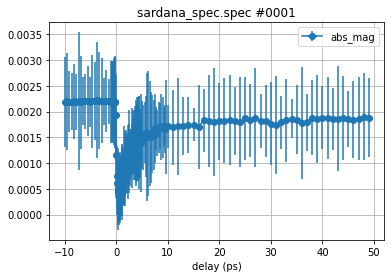

In [15]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1, 2, 3, 4, 5, 6], xgrid=np.r_[-10:50:0.1])
plt.xlabel('delay (ps)')
plt.show()

Hm, somehow this did not really did the job, right?
Let's check the individual scans to see what happened:

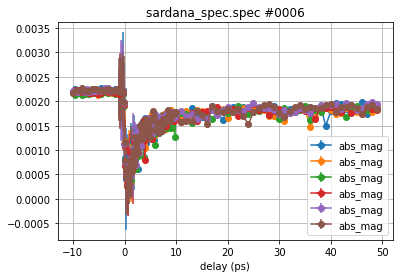

In [16]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([2], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([3], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([4], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([5], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([6], xgrid=np.r_[-10:50:0.1])
plt.xlabel('delay (ps)')
plt.show()

Individually all scans look very much the same, so why do we get so large errorbars
when we average them?

Let's go one more step back and plot the `Unpumped` signal for all scans with a
large grid of 5 ps for clarity:

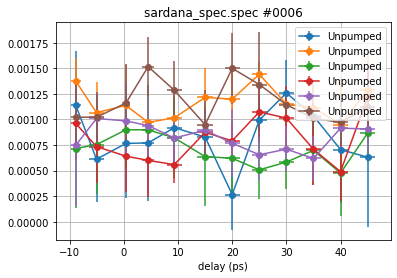

In [17]:
ev.xcol = 'delay'
ev.clist = ['Unpumped']

plt.figure()
ev.plot_scans([1], xgrid=np.r_[-10:50:5])
ev.plot_scans([2], xgrid=np.r_[-10:50:5])
ev.plot_scans([3], xgrid=np.r_[-10:50:5])
ev.plot_scans([4], xgrid=np.r_[-10:50:5])
ev.plot_scans([5], xgrid=np.r_[-10:50:5])
ev.plot_scans([6], xgrid=np.r_[-10:50:5])
plt.xlabel('delay (ps)')
plt.show()

We can observe a significant drift of the raw data which results in deviations
that are not statistically distributed anymore.

This essentially means, that it is differs if we  
1. take evaluate the expression `abs_mag` for every scan individually and
   eventually average the resulting traces  
2. if we first average the raw data (`Pumped, PumpedM, Unpumped, UnpumpedM`)
   and then calculate final trave for `abs_mag` using the averages. In the later
   case we need to carry out a proper error propagation to determine the errors
   for `abs_mag`.

The `Evaluation` class allows to switch between both cases by the attribute flag
`propagate_errors` which is `True` by default.
This means that our last example was carried out following option 2. as described
above. Accoridngly, propagated rather large errors from the drifiting raw signals.

Now lets compare to option 1. without error propagation:

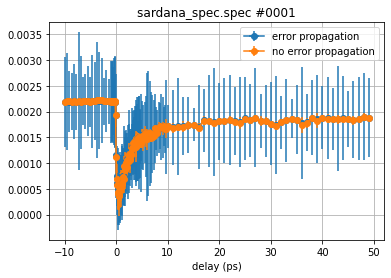

In [18]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.propagate_errors = True
ev.plot_scans([1, 2, 3, 4, 5, 6], xgrid=np.r_[-10:50:0.1])

ev.propagate_errors = False
ev.plot_scans([1, 2, 3, 4, 5, 6], xgrid=np.r_[-10:50:0.1])
plt.xlabel('delay (ps)')
plt.legend(['error propagation', 'no error propagation'])
plt.show()

The application of the both options strongly depends on the type of noise and 
drifts of the acquired data.

## Scan sequences

In [19]:
# to be done

## Fit scan sequences

In [20]:
# to be done

### Access fit results

In [21]:
# to be done